In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

import shap
import math
from sklearn.metrics import r2_score
from itertools import chain, combinations

In [33]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

In [34]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [35]:
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]

In [36]:
all_features = train_cut_X.columns

In [37]:
i = all_features[0]
N = all_features[1:]

In [39]:
def set(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

set_N = list(set(N))
set_N

[(),
 ('battery-capacity',),
 ('charge-time',),
 ('compression',),
 ('consumption-mixed',),
 ('battery-capacity', 'charge-time'),
 ('battery-capacity', 'compression'),
 ('battery-capacity', 'consumption-mixed'),
 ('charge-time', 'compression'),
 ('charge-time', 'consumption-mixed'),
 ('compression', 'consumption-mixed'),
 ('battery-capacity', 'charge-time', 'compression'),
 ('battery-capacity', 'charge-time', 'consumption-mixed'),
 ('battery-capacity', 'compression', 'consumption-mixed'),
 ('charge-time', 'compression', 'consumption-mixed'),
 ('battery-capacity', 'charge-time', 'compression', 'consumption-mixed')]

In [40]:
selected = []
for col in train_cut_X.columns: # цикл по столбцам (важность каждого)
    s = list(set(train_cut_X.columns)) # все возможные подмножества
    k = 0
    for _ in s:
        n = (math.factorial(len(s))*math.factorial((len(train_cut_X.columns)+len(s))))/math.factorial(len(train_cut_X.columns))
        model = LinearRegression().fit(train_cut_X, train_y)
        predictions = model.predict(test_cut_X)
        R2 = r2_score(test_y, predictions)

        train_cut_X_drop = train_cut_X.drop(col, axis=1)
        test_cut_X_drop = test_cut_X.drop(col, axis=1)
        reg1 = LinearRegression().fit(train_cut_X_drop, train_y)
        predictions1 = reg1.predict(test_cut_X_drop)

        R_2 = r2_score(test_y, predictions1)
        k += n*(R2**2-R_2**2)
    selected.append(k)
selected

[7.844275671031226e+74,
 9.28468710963701e+73,
 3.686803539176758e+74,
 3.377456271422292e+71,
 5.216844990633186e+74]

In [41]:
#признак - важность
importance_dict = dict(zip(train_cut_X.columns, selected))
for feature, importance in importance_dict.items():
    print(f"признак: {feature}, важность: {importance}")

признак: back-suspension, важность: 7.844275671031226e+74
признак: battery-capacity, важность: 9.28468710963701e+73
признак: charge-time, важность: 3.686803539176758e+74
признак: compression, важность: 3.377456271422292e+71
признак: consumption-mixed, важность: 5.216844990633186e+74


In [42]:
def shap_alg(s2, a):
  fi = 0
  for i in s2:
    b = i.copy()
    train_cut_X_1 = train_cut_X[i]
    test_cut_X_1 = test_cut_X[i]
    reg1 = LinearRegression().fit(train_cut_X_1, train_y)
    b.append(a)
    train_cut_X_2 = train_cut_X[b]
    test_cut_X_2 = test_cut_X[b]
    reg2 = LinearRegression().fit(train_cut_X_2, train_y)
    fi += (math.factorial(len(x))*math.factorial(5- len(i) - 1)/math.factorial(5))*(mean_squared_error(reg1.predict(test_cut_X_1), test_y) - mean_squared_error(reg2.predict(test_cut_X_2), test_y) )
  return fi

In [43]:
#MSE для всех признаков
MSE = mean_squared_error(test_y, predictions)
print('MSE:', MSE)

MSE: 55826.5154137429


In [44]:
#MSE для всех признаков кроме одного
MSE1 = mean_squared_error(test_y, predictions1)
print('MSE1:', MSE1)

MSE1: 56310.354332582


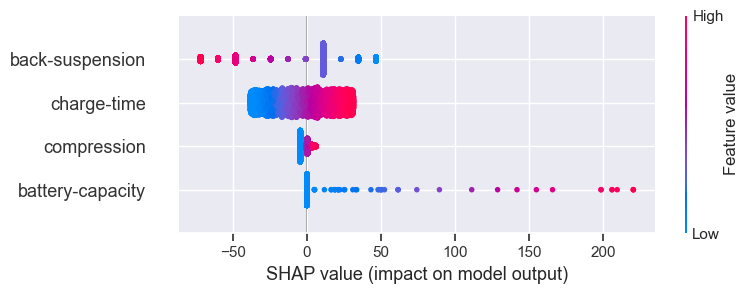

In [45]:
reg1 = LinearRegression().fit(train_cut_X_drop, train_y)
explainer = shap.Explainer(reg1, train_cut_X_drop)
shap_values = explainer(test_cut_X_drop)

shap.summary_plot(shap_values, test_cut_X_drop)